In [1]:
import os
import json

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from mtgc.ai.preprocessing import CardPreprocessor
from mtgc.ai.dataset import DraftDataset
from mtgc.ai.model import DraftPicker

# Prepare data

In [2]:
draft_data_dtypes_path = "../data/mkm/17lands/draft_data_public.MKM.PremierDraft.columns.json"
draft_data_path = "../data/mkm/17lands/draft_data_public.MKM.PremierDraft.csv"

In [3]:
with open(draft_data_dtypes_path, "r") as f:
    dtypes_dict = json.load(f)

draft_data_df = pd.read_csv(draft_data_path, dtype=dtypes_dict)

In [4]:
mkm_card_folder = "../data/mkm/cards"

In [5]:
cards_data_dict = {}

for filename in os.listdir(mkm_card_folder):
    file_path = os.path.join(mkm_card_folder, filename)
    card_name = filename.split(".")[0]
    
    with open(file_path, "r") as f:
        card_json_dict = json.load(f)

    cards_data_dict[card_name] = card_json_dict

In [6]:
draft_data_df = draft_data_df[draft_data_df["user_game_win_rate_bucket"] >= 0.62].reset_index(drop=True)

In [7]:
draft_data_df = draft_data_df[draft_data_df["user_n_games_bucket"] >= 100].reset_index(drop=True)

In [8]:
# FIXME: Handle cases like 'Kellan, Inquisitive Prodigy // Tail the Suspect'
draft_data_df = draft_data_df[draft_data_df["pick"].isin(cards_data_dict)].reset_index(drop=True)

In [9]:
pack_columns = [column for column in draft_data_df.columns if "pack_card_" in column]
draft_data_df = draft_data_df[draft_data_df[pack_columns].sum(axis=1) >= 2].reset_index(drop=True)

In [10]:
pool_columns = [column for column in draft_data_df.columns if "pool_" in column]
draft_data_df = draft_data_df[draft_data_df[pool_columns].sum(axis=1) >= 1].reset_index(drop=True)

In [11]:
draft_data_df.shape

(393499, 666)

In [12]:
card_preprocessor = CardPreprocessor(
    card_type_vocabulary = [
        "Land",
        "Creature",
        "Artifact",
        "Enchantment",
        "Planeswalker",
        "Battle",
        "Instant",
        "Sorcery"
    ],
    keyword_vocabulary = [
        "Attach",
        "Counter",
        "Exile",
        "Fight",
        "Mill",
        "Sacrifice",
        "Scry",
        "Tap",
        "Untap",
        "Deathtouch",
        "Defender",
        "Double strike",
        "Enchant",
        "Equip",
        "First strike",
        "Flash",
        "Flying",
        "Haste",
        "Hexproof",
        "Indestructible",
        "Lifelink",
        "Menace",
        "Protection",
        "Prowess",
        "Reach",
        "Trample",
        "Vigilance"
    ]
)

In [13]:
draft_dataset = DraftDataset(
    draft_data_df=draft_data_df,
    cards_data_dict=cards_data_dict,
    card_preprocessor=card_preprocessor
)

In [14]:
training_draft_dataset, validation_draft_dataset = torch.utils.data.random_split(draft_dataset, [0.8, 0.2])

# Training

In [15]:
n_epochs = 10
n_cumulation_steps = 100
learning_rate = 1e-4

device = torch.device("cuda")

In [16]:
model = DraftPicker(
    input_dim=45,
    transformer_encoder_n_layers=10,
    transformer_encoder_layer_dim=128,
    transformer_encoder_layer_n_heads=8
).to(device)

/home/gcoter/projects/personal/magic-the-gathering-collection/venv/lib/python3.8/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [17]:
model

DraftPicker(
  (input_mlp): Sequential(
    (0): Linear(in_features=45, out_features=128, bias=True)
    (1): ReLU()
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-9): 10 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (output_mlp): Sequential(
    (0): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [18]:
sum(p.numel() for p in model.parameters())

5936257

In [19]:
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

In [20]:
training_cumulated_loss = 0.0
n_steps_since_last_cumulation = 0
training_draft_dataset_indices = np.arange(len(training_draft_dataset))
loss_history = {"step": [], "training_loss": []}

In [21]:
model.train()

for n in range(n_epochs):
    print(f"===== Epoch {n + 1}/{n_epochs} =====")
    np.random.shuffle(training_draft_dataset_indices)
    for i, training_draft_dataset_index in enumerate(training_draft_dataset_indices):
        x, y = training_draft_dataset[training_draft_dataset_index]
        x = x.to(device)
        y = y.to(device)
        y_logits = model(x)

        pack_card_mask = x[..., -1].bool()
        y = y[pack_card_mask]
        y_logits = y_logits[pack_card_mask]

        loss = torch.nn.functional.cross_entropy(y_logits, y)
        training_cumulated_loss += loss.cpu().detach().numpy()
        n_steps_since_last_cumulation += 1
        loss.backward()

        if (i > 0 and i % n_cumulation_steps == 0) or (i == len(training_draft_dataset_indices) - 1):
            training_cumulated_loss = training_cumulated_loss / n_steps_since_last_cumulation
            loss_history["step"].append(n * len(training_draft_dataset_indices) + i)
            loss_history["training_loss"].append(training_cumulated_loss)
            print(f"{i}/{len(training_draft_dataset)}: {training_cumulated_loss:.4f}")
            optimizer.step()
            optimizer.zero_grad()
            training_cumulated_loss = 0.0
            n_steps_since_last_cumulation = 0

===== Epoch 1/10 =====
100/314800: 1.2942
200/314800: 1.3195
300/314800: 1.1806
400/314800: 1.2978
500/314800: 1.2738
600/314800: 1.3103
700/314800: 1.3864
800/314800: 1.4251
900/314800: 1.2652
1000/314800: 1.4306
1100/314800: 1.3681
1200/314800: 1.3661
1300/314800: 1.2997
1400/314800: 1.2382
1500/314800: 1.2512
1600/314800: 1.3707
1700/314800: 1.3125
1800/314800: 1.3815
1900/314800: 1.5275
2000/314800: 1.1957
2100/314800: 1.1795
2200/314800: 1.3868
2300/314800: 1.2230
2400/314800: 1.3640
2500/314800: 1.3978
2600/314800: 1.4337
2700/314800: 1.4148
2800/314800: 1.3302
2900/314800: 1.3072
3000/314800: 1.5692
3100/314800: 1.2742
3200/314800: 1.2844
3300/314800: 1.2920
3400/314800: 1.4038
3500/314800: 1.3656
3600/314800: 1.4178
3700/314800: 1.2319
3800/314800: 1.3818
3900/314800: 1.3858
4000/314800: 1.1410
4100/314800: 1.2408
4200/314800: 1.3415
4300/314800: 1.4016
4400/314800: 1.4374
4500/314800: 1.2273
4600/314800: 1.2277
4700/314800: 1.2934
4800/314800: 1.4236
4900/314800: 1.5635
5000/3

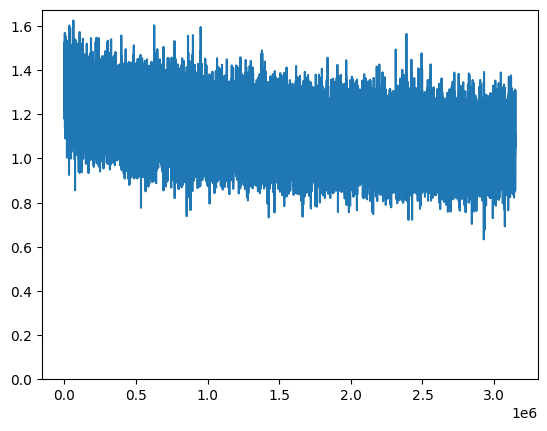

In [22]:
plt.plot(loss_history["step"], loss_history["training_loss"])
plt.ylim(bottom=0.0)
plt.show()

In [23]:
correct_count = 0
random_correct_count = 0
model.eval()

for i, (x, y) in enumerate(validation_draft_dataset):
    if i > 0 and i % 1000 == 0:
        print(f"{i}/{len(validation_draft_dataset)}")

    x = x.to(device)
    y = y.to(device)
    y_logits = model(x)

    pack_card_mask = x[..., -1].bool()
    y = y[pack_card_mask]
    y_logits = y_logits[pack_card_mask]

    if torch.argmax(y_logits) == torch.argmax(y):
        correct_count += 1

    if torch.randint(len(y), size=(1,))[0] == torch.argmax(y):
        random_correct_count += 1

accuracy = 100 * correct_count / len(validation_draft_dataset)
random_accuracy = 100 * random_correct_count / len(validation_draft_dataset)
print(f"Validation Accuracy: {accuracy:.1f}% (random: {random_accuracy:.1f}%)")

1000/78699
2000/78699
3000/78699
4000/78699
5000/78699
6000/78699
7000/78699
8000/78699
9000/78699
10000/78699
11000/78699
12000/78699
13000/78699
14000/78699
15000/78699
16000/78699
17000/78699
18000/78699
19000/78699
20000/78699
21000/78699
22000/78699
23000/78699
24000/78699
25000/78699
26000/78699
27000/78699
28000/78699
29000/78699
30000/78699
31000/78699
32000/78699
33000/78699
34000/78699
35000/78699
36000/78699
37000/78699
38000/78699
39000/78699
40000/78699
41000/78699
42000/78699
43000/78699
44000/78699
45000/78699
46000/78699
47000/78699
48000/78699
49000/78699
50000/78699
51000/78699
52000/78699
53000/78699
54000/78699
55000/78699
56000/78699
57000/78699
58000/78699
59000/78699
60000/78699
61000/78699
62000/78699
63000/78699
64000/78699
65000/78699
66000/78699
67000/78699
68000/78699
69000/78699
70000/78699
71000/78699
72000/78699
73000/78699
74000/78699
75000/78699
76000/78699
77000/78699
78000/78699
Validation Accuracy: 50.5% (random: 18.9%)


In [24]:
torch.save(model.state_dict(), "../models/draft_picker_mkm.pt")